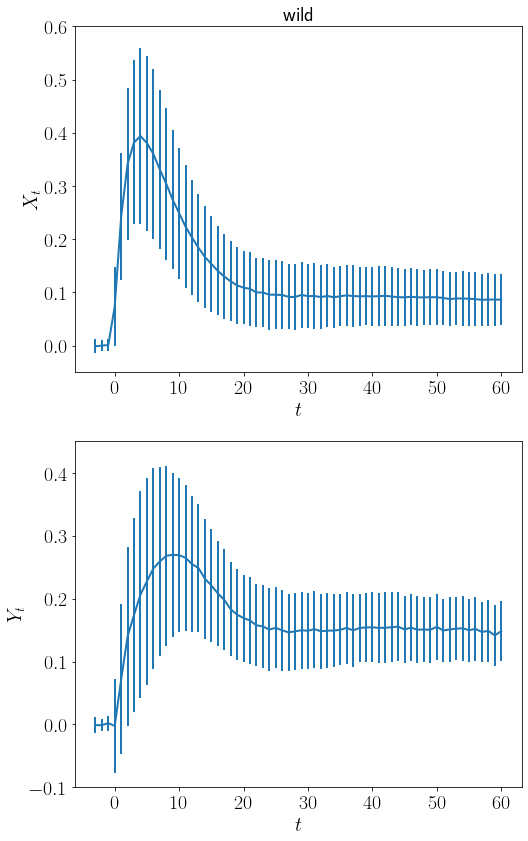

In [12]:
%matplotlib inline 
import numpy as np
from numpy import exp, log, sqrt, pi, sin, cos
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd

np.random.seed(seed = 13)

# Choose 'wild' or 'mutant'
DIR = 'wild'

# Lag Parameters
p_list = [1,2,3]
q_list = [1,2,3]
TE_y2x_dict = {}
TE_x2y_dict = {}
H_x2x_dict = {}
H_y2y_dict = {}
H_x_dict = {}
H_y_dict = {}


# Read Dataset
X = pd.read_csv(DIR+'/sos.csv', na_values = '#VALUE!', index_col = 0)
X.dropna(how = 'any', axis = 1, inplace = True)
X.set_axis(['{}'.format(n) for n in range(X.shape[1])], axis ='columns', inplace = True)
X = X.to_numpy()

Y = pd.read_csv(DIR+'/raf.csv', na_values = '#VALUE!', index_col = 0)
Y.dropna(how = 'any', axis = 1, inplace = True)
Y.set_axis(['{}'.format(n) for n in range(Y.shape[1])], axis ='columns', inplace = True)
Y = Y.to_numpy()

# Length of TIme Serires
T = X.shape[0]
time = np.array([t for t in range(T)]) -3
# Sample Size
NSAMP = X.shape[1]

# Data Concatenation 
x = np.zeros((2, T, NSAMP))
x[0, :, :] = X
x[1, :, :] = Y
z = np.concatenate([x[0, :, :], x[1, :, :]], axis = 0)
C_tot = np.cov(z)

# Plot Raw Time Series
rc('text', usetex=True)
rc('lines', linewidth=2)
rc('xtick', labelsize = 20)
rc('ytick', labelsize = 20)

plt.figure(figsize = (8, 14))
plt.subplot(2,1,1)
plt.title('{}'.format(DIR), fontsize = 20)
plt.errorbar(time, x[0, :, :].mean(axis=1), x[0, :, :].std(axis=1))
plt.xlabel(r'$t$', fontsize = 20)
plt.ylabel(r'$X_t$', fontsize = 20)
plt.ylim(-0.05, 0.6)


plt.subplot(2,1,2)
plt.errorbar(time, x[1, :, :].mean(axis=1), x[0, :, :].std(axis=1))
plt.xlabel(r'$t$', fontsize = 20)
plt.ylabel(r'$Y_t$', fontsize = 20)

plt.ylim(-0.1, 0.45)
plt.show()

In [14]:
# Assessment of TE for Various Lag Parameters
time = [t-3 for t in range(T)]
EPS = 1.0e-8
for p in p_list:
    for q in q_list:
 
        TE_y2x = np.zeros((T,))
        TE_x2y = np.zeros((T,))

        for t in range(1,T):
            
            LagX = min(t,p)
            LagY = min(t,q)
            u = np.concatenate((x[0, t-LagX: t, :], x[1, t - LagY: t, :]), axis = 0)

            # TE_y2x
            z = np.concatenate((x[0, t, :].reshape(1,u.shape[1]), u), axis = 0)
            C = np.cov(z)
            Vx_xy = C[0,0] - C[0,1:]@np.linalg.inv(C[1:,1:] + EPS*np.eye(LagX+LagY) )@C[1:,0]
            Vx_x = C[0,0] - C[0,1: LagX+1]@np.linalg.inv(C[1:LagX+1, 1:LagX+1] + EPS*np.eye(LagX))@C[1: LagX+1, 0]
            TE_y2x[t] = 1/2*log(Vx_x/Vx_xy)


            # TE_x2y
            z = np.concatenate((x[1, t, :].reshape(1,u.shape[1]), u), axis = 0)
            C = np.cov(z)
            Vy_xy = C[0,0] - C[0,1:]@np.linalg.inv(C[1:,1:] + EPS*np.eye(LagX+LagY))@C[1:,0]
            Vy_y = C[0,0] - C[0, LagX+1:]@np.linalg.inv(C[LagX+1:, LagX+1:] + EPS*np.eye(LagY))@C[LagX+1:, 0]
            TE_x2y[t] = 1/2*log(Vy_y/Vy_xy)


        TE_y2x_dict['{}{}'.format(q,p)] = TE_y2x            
        TE_x2y_dict['{}{}'.format(p,q)] = TE_x2y

        

In [15]:
# Bootstrap Assessment of Sampling Distribution 
B = 1000

TE_x2y_BS_dict = {}
TE_y2x_BS_dict = {}

LAM, U = np.linalg.eigh(C_tot)

for p in p_list:
    for q in q_list:      
        TE_y2x_BS = np.zeros((T, B))
        TE_x2y_BS = np.zeros((T, B))


        for b in range(B):

            # Generation of Bootstrap Data
            x_BS = np.zeros((2,T, NSAMP))
            u = U@np.diag(sqrt(abs(LAM)))@np.random.randn(2*T, NSAMP)
            x_BS[0, :, :] = u[:T, :]
            x_BS[1, :, :] = u[T:, :]

            for t in range(1,T):
                
                # TE_y2x
                LagX = min(t, p)
                LagY = min(t, q)
                u = np.concatenate((x_BS[0, t-LagX: t, :], x_BS[1, t - LagY: t, :]), axis = 0)
                z = np.concatenate((x_BS[0, t, :].reshape(1,u.shape[1]), u), axis = 0)
                C = np.cov(z)
                Vx_xy = C[0,0] - C[0,1:]@np.linalg.inv(C[1:,1:] + EPS*np.eye(LagX+LagY))@C[1:,0]
                Vx_x = C[0,0] - C[0,1: LagX+1]@np.linalg.inv(C[1:LagX+1, 1:LagX+1] + EPS*np.eye(LagX))@C[1: LagX+1, 0]
                TE_y2x_BS[t, b] = 1/2*log(Vx_x/Vx_xy)

                # TE_x2y
                LagX = min(t, p)
                LagY = min(t, q)
                u = np.concatenate((x_BS[0, t-LagX: t, :], x_BS[1, t - LagY: t, :]), axis = 0)
                z = np.concatenate((x_BS[1, t, :].reshape(1,u.shape[1]), u), axis = 0)
                C = np.cov(z)
                Vy_xy = C[0,0] - C[0,1:]@np.linalg.inv(C[1:,1:] + EPS*np.eye(LagX+LagY))@C[1:,0]
                Vy_y = C[0,0] - C[0, LagX+1:]@np.linalg.inv(C[LagX+1:, LagX+1:] + EPS*np.eye(LagY))@C[LagX+1:, 0]
                TE_x2y_BS[t, b] = 1/2*log(Vy_y/Vy_xy)
                
        TE_y2x_BS_dict['{}{}'.format(q,p)] = TE_y2x_BS
        TE_x2y_BS_dict['{}{}'.format(p,q)] = TE_x2y_BS        
    

In [16]:
# Bootstrap Assessment of Sampling Distribution for Null Hypothesis 
B = 1000


# Null Hypothesis 
C_null = C_tot
C_null[:T, T:] = np.zeros((T,T)) 
C_null[T:, :T] = np.zeros((T,T)) 
LAM, U = np.linalg.eigh(C_null)

TE_y2x_shuffled_dict = {}
TE_x2y_shuffled_dict = {}
for p in p_list:
    for q in q_list:
        TE_y2x_shuffled = np.zeros((T, B))
        TE_x2y_shuffled = np.zeros((T, B))


        for b in range(B):

            # Generation of Bootstrap Data
            x_BS = np.zeros((2,T, NSAMP))
            u = U@np.diag(sqrt(abs(LAM)))@np.random.randn(2*T, NSAMP)
            x_BS[0, :, :] = u[:T, :]
            x_BS[1, :, :] = u[T:, :]

            for t in range(1,T):

                # TE_y2x
                LagX = min(t,p)
                LagY = min(t,q)
                u = np.concatenate((x_BS[0, t-LagX: t, :], x_BS[1, t - LagY: t, :]), axis = 0)
                z = np.concatenate((x_BS[0, t, :].reshape(1,u.shape[1]), u), axis = 0)
                C = np.cov(z)
                Vx_xy = C[0,0] - C[0,1:]@np.linalg.inv(C[1:,1:] + EPS*np.eye(LagX+LagY))@C[1:,0]
                Vx_x = C[0,0] - C[0,1: LagX+1]@np.linalg.inv(C[1:LagX+1, 1:LagX+1] + EPS*np.eye(LagX))@C[1: LagX+1, 0]
                TE_y2x_shuffled[t, b] = 1/2*log(Vx_x/Vx_xy)

                # TE_x2y
                LagX = min(t,p)
                LagY = min(t,q)
                u = np.concatenate((x_BS[0, t-LagX: t, :], x_BS[1, t - LagY: t, :]), axis = 0)
                z = np.concatenate((x_BS[1, t, :].reshape(1,u.shape[1]), u), axis = 0)
                C = np.cov(z)
                Vy_xy = C[0,0] - C[0,1:]@np.linalg.inv(C[1:,1:] + EPS*np.eye(LagX+LagY))@C[1:,0]
                Vy_y = C[0,0] - C[0, LagX+1:]@np.linalg.inv(C[LagX+1:, LagX+1:] + EPS*np.eye(LagY))@C[LagX+1:, 0]
                TE_x2y_shuffled[t, b] = 1/2*log(Vy_y/Vy_xy)
                
        TE_y2x_shuffled_dict['{}{}'.format(q,p)] = TE_y2x_shuffled
        TE_x2y_shuffled_dict['{}{}'.format(p,q)] = TE_x2y_shuffled   


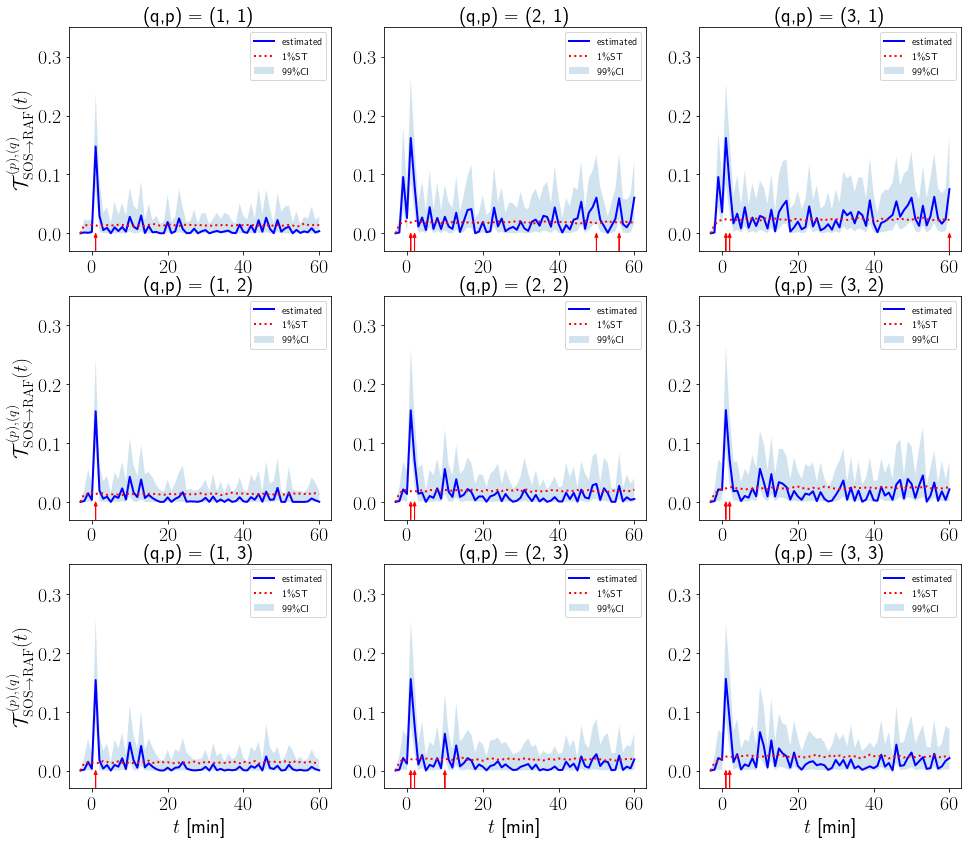

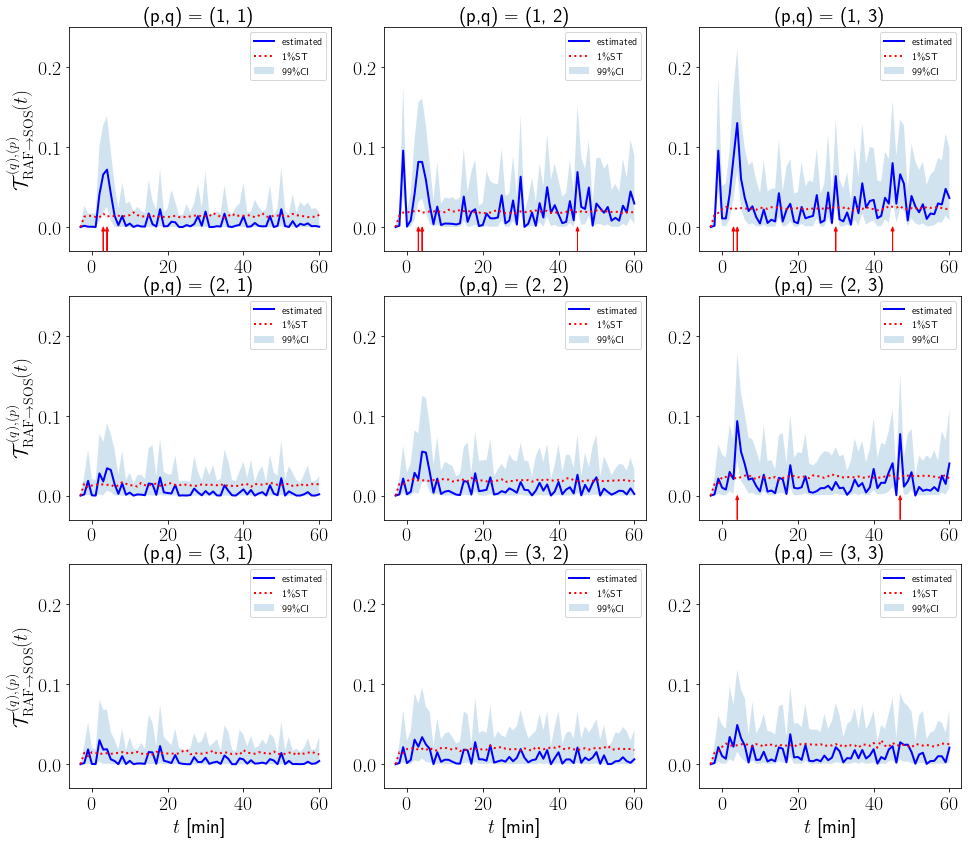

In [17]:
pr = 0.01

 # Plot
rc('text', usetex=True)

# TE_x2y
fig, axes = plt.subplots(3,3, figsize = (16,14))
for q in q_list: 
    for p in p_list:

        TE_x2y = TE_x2y_dict['{}{}'.format(p,q)]
        TE_x2y_BS = TE_x2y_BS_dict['{}{}'.format(p,q)]
        TE_x2y_shuffled = TE_x2y_shuffled_dict['{}{}'.format(p,q)]
        
        
        # Sort for Confidence Interval 
        for t in range(T):
            TE_x2y_BS[t, :] = np.sort(TE_x2y_BS[t,:])
        # Sort for Significance Threshold
        for t in range(T):
            TE_x2y_shuffled[t,:] = np.sort(TE_x2y_shuffled[t, :])   
            
        # TE Assessed from Data
        axes[q-1,p-1].plot(time, TE_x2y, color = 'blue', label = 'estimated')
        # Confidence Interval 
        axes[q-1,p-1].fill_between(time, TE_x2y_BS[:, int(pr/2*B)], TE_x2y_BS[:, B-int(pr/2*B)], alpha = .2, label = r'{}\%CI'.format(100-int(100*pr)))
        # Significance Threshold
        axes[q-1,p-1].plot(time, TE_x2y_shuffled[:, B-int(pr*B)], linestyle = ':', color = 'red', label = r'{}\%ST'.format(int(100*pr)))
        axes[q-1,p-1].set_title('(q,p) = ({}, {})'.format(p,q), fontsize = 20)
        if q == 3:
            axes[q-1,p-1].set_xlabel(r'$t$ [min]', fontsize = 20)
        if p == 1:
            axes[q-1,p-1].set_ylabel(r'${\mathcal T}_{{{\rm SOS} \to {\rm RAF}}}^{(p), (q)}(t)$', fontsize = 20)
        axes[q-1,p-1].set_ylim(-0.03,0.35)
        axes[q-1,p-1].legend()
        
        for t in range(3, T):
            if TE_x2y_BS[t, int(pr/2*B)] > TE_x2y_shuffled[t, B-int(pr*B)]:
                axes[q-1, p-1].annotate('', xy = [time[t], 0], \
                             xytext = [time[t], -0.03], \
                             arrowprops=dict(width = 0.03, headwidth = 3, headlength = 4, facecolor = 'red', edgecolor = 'red')
                            )
        
plt.show()

# TE_y2x 
fig, axes = plt.subplots(3,3, figsize = (16,14))
for p in p_list:
    for q in q_list: 

        TE_y2x = TE_y2x_dict['{}{}'.format(q,p)]
        TE_y2x_BS = TE_y2x_BS_dict['{}{}'.format(q,p)]
        TE_y2x_shuffled = TE_y2x_shuffled_dict['{}{}'.format(q,p)]
        
        
        # Sort for Confidence Interval 
        for t in range(T):
            TE_y2x_BS[t, :] = np.sort(TE_y2x_BS[t,:])
        # Sort for Significance Threshold
        for t in range(T):
            TE_y2x_shuffled[t,:] = np.sort(TE_y2x_shuffled[t, :])          

        # TE Assessed from Data    
        axes[p-1,q-1].plot(time, TE_y2x, color = 'blue', label = 'estimated')
        # Confidence Interval 
        axes[p-1,q-1].fill_between(time, TE_y2x_BS[:, int(pr/2*B)], TE_y2x_BS[:, B-int(pr/2*B)], alpha = .2, label = r'{}\%CI'.format(100-int(100*pr)))
        # Significance Threshold
        axes[p-1,q-1].plot(time, TE_y2x_shuffled[:, B-int(pr*B)], linestyle = ':', color = 'red', label = r'{}\%ST'.format(int(100*pr)))
        axes[p-1,q-1].set_title('(p,q) = ({}, {})'.format(p,q), fontsize = 20)
        if p == 3:
            axes[p-1,q-1].set_xlabel(r'$t$ [min]', fontsize = 20)
        if q == 1:
            axes[p-1,q-1].set_ylabel(r'${\mathcal T}_{{{\rm RAF} \to {\rm SOS}}}^{(q), (p)}(t)$', fontsize = 20)
        axes[p-1,q-1].set_ylim(-0.03,0.25)
        axes[p-1,q-1].legend()
        
        for t in range(3, T):
            if TE_y2x_BS[t, int(pr/2*B)] > TE_y2x_shuffled[t, B-int(pr*B)]:
                axes[p-1,q-1].annotate('', xy = [time[t], 0], \
                             xytext = [time[t], -0.03], \
                             arrowprops=dict(width = 0.05, headwidth = 3, headlength = 4, facecolor = 'red', edgecolor = 'red')
                            )

plt.show()
